# Fecha de entrega: 27/08/2022 (corresponde a clase 20)

# Reajuste de base de datos BTC_metals

El objetivo de este notebook es reajustar el data set "BTC_metals.csv" según las conclusiones alcanzadas al momento de llevarse a cabo su corerspondiente análisis univariado, bivariado y multivariado (ver, "Primera entrega.docx", "Metadata.docx", y/o "Análisis univariado, bivariado y multivariado de BTC_metals.ipynb"). 

En concreto, se procederá a eliminar las variables originales del data set que fueron descartadas según los criterios establecidos en el punto 7 del documento "Primera entrega.docx", y se agregarán las variables [Trend] y [Residuals] (propias de una serie de tiempo).

Así, el data set "BTC_metals_fv.csv" (que se crea al final de este notebook) solo requerirá manipulaciones menores al momento de ser procesado por los diversos modelos de ML en lo que resta del proyecto.

# Librearías

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas_profiling
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.cm import ScalarMappable

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('darkgrid')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Data acquisition

In [3]:
def gdriveColabPath(sharing_url):
  file_id=sharing_url.split('/')[-2]
  dwn_url='https://drive.google.com/uc?id=' + file_id
  return dwn_url

## Adquiriendo BTC_metals

In [4]:
# Se carga la base de datos de BTC_metals desde la carpeta compartida en el Google Drive
sharing_url = "https://drive.google.com/file/d/1Mw8RrLFMLLgnRTQ0gK3XAO4kgR98orwY/view?usp=sharing"

In [5]:
dwn_url=gdriveColabPath(sharing_url)
BTC_metals_df = pd.read_csv(dwn_url, sep=";", decimal=".")
BTC_metals_df.head()

,Date,Price,Open,High,Low,Vol.,Percentage_diff,Target,Price_gold,Perc_diff_gold,Price_silver,Perc_diff_silver,Price_copper,Perc_diff_copper,Price_aluminium,Perc_diff_aluminium,Price_platinum,Perc_diff_platinum,Price_palladium,Perc_diff_palladium
0,2014-06-23,591.2,603.6,604.7,582.9,2650.0,-2.06,0.0,1318.0,0.14,20.909,0.16,3.146,0.90,1892.5,0.21,1454.10,-0.21,823.60,0.08
1,2014-06-24,588.8,591.2,595.7,585.4,3080.0,-0.41,0.0,1320.9,0.22,21.038,0.62,3.147,0.03,1901.0,0.45,1471.55,1.20,831.80,1.00
2,2014-06-25,568.5,588.8,589.6,566.9,3090.0,-3.45,0.0,1322.2,0.10,21.111,0.35,3.160,0.41,1903.5,0.13,1469.80,-0.12,834.25,0.29
3,2014-06-26,582.7,568.5,582.7,565.8,4150.0,2.51,1.0,1316.1,-0.46,21.103,-0.04,3.161,0.03,1898.0,-0.29,1470.85,0.07,835.80,0.19
4,2014-06-27,602.2,582.7,603.9,580.1,3390.0,3.35,1.0,1319.0,0.22,21.077,-0.12,3.149,-0.38,1885.0,-0.68,1480.40,0.65,843.25,0.89


# Data wrangling

Según se puede leer en el documento de trabajo "Primera entrega.docx", item 7, luego de ejecutarse el análisis univariado, bivariado y multivariado de "BTC_metals.csv", se redujo la cantidad de variables del mismo según diversos criterios de selección allí explicitados.

En primera instancia se eliminarán las variables que no se van a utilizar, y en un segundo término, se agregarán las variables ausentes en BTC_metals.csv que se consideraron relevantes incoprotar para el momento del modelado (i.e. [Trend] y [Residuals]).

In [6]:
BTC_metals_df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Percentage_diff',
       'Target', 'Price_gold', 'Perc_diff_gold', 'Price_silver',
       'Perc_diff_silver', 'Price_copper', 'Perc_diff_copper',
       'Price_aluminium', 'Perc_diff_aluminium', 'Price_platinum',
       'Perc_diff_platinum', 'Price_palladium', 'Perc_diff_palladium'],
      dtype='object')

PASO 1 -> se eliminan las variables que no se van a utilizar

In [7]:
BTC_metals_df_reduced = BTC_metals_df [['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Percentage_diff',
       'Target', 'Price_gold', 'Perc_diff_gold', 'Price_copper', 'Perc_diff_copper',
       'Price_aluminium', 'Perc_diff_aluminium']]

In [8]:
# Se revisa las columnas del nuevo dataframe
BTC_metals_df_reduced.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Percentage_diff',
       'Target', 'Price_gold', 'Perc_diff_gold', 'Price_copper',
       'Perc_diff_copper', 'Price_aluminium', 'Perc_diff_aluminium'],
      dtype='object')

In [9]:
# Se revisa la cantidad de datos en cada variable/columna del nuevo dataframe
BTC_metals_df_reduced.count()

Date                   2949
Price                  2949
Open                   2949
High                   2949
Low                    2949
Vol.                   2949
Percentage_diff        2949
Target                 2949
Price_gold             2949
Perc_diff_gold         2949
Price_copper           2949
Perc_diff_copper       2949
Price_aluminium        2949
Perc_diff_aluminium    2949
dtype: int64

Paso 2 -> se calcula y agregan las columnas ausentes [Trend] y [Residuals]

In [10]:
BTC_metals_df_reduced.dtypes

Date                    object
Price                  float64
Open                   float64
High                   float64
Low                    float64
Vol.                   float64
Percentage_diff        float64
Target                 float64
Price_gold             float64
Perc_diff_gold         float64
Price_copper           float64
Perc_diff_copper       float64
Price_aluminium        float64
Perc_diff_aluminium    float64
dtype: object

In [11]:
# Se convierte la varibale [Date] a datetime64 a fin de poder calcular la descomposición de la serie de tiempo (var=[Price])
BTC_metals_df_reduced ["Date"] = pd.to_datetime (BTC_metals_df_reduced ["Date"])

In [12]:
BTC_metals_df_reduced.dtypes

Date                   datetime64[ns]
Price                         float64
Open                          float64
High                          float64
Low                           float64
Vol.                          float64
Percentage_diff               float64
Target                        float64
Price_gold                    float64
Perc_diff_gold                float64
Price_copper                  float64
Perc_diff_copper              float64
Price_aluminium               float64
Perc_diff_aluminium           float64
dtype: object

In [13]:
# Se reindexa BTC_metals_df_reduced con la variable [Date] como nuevo índice
BTC_metals_df_reduced_2 = BTC_metals_df_reduced.set_index("Date")

In [14]:
# Se procede a calcular las variables [Trend] y [Residuals] y a agregarlas a BTC_metals_df_reduced
descomposicion = sm.tsa.seasonal_decompose(BTC_metals_df_reduced_2 ['Price'], model='additive')

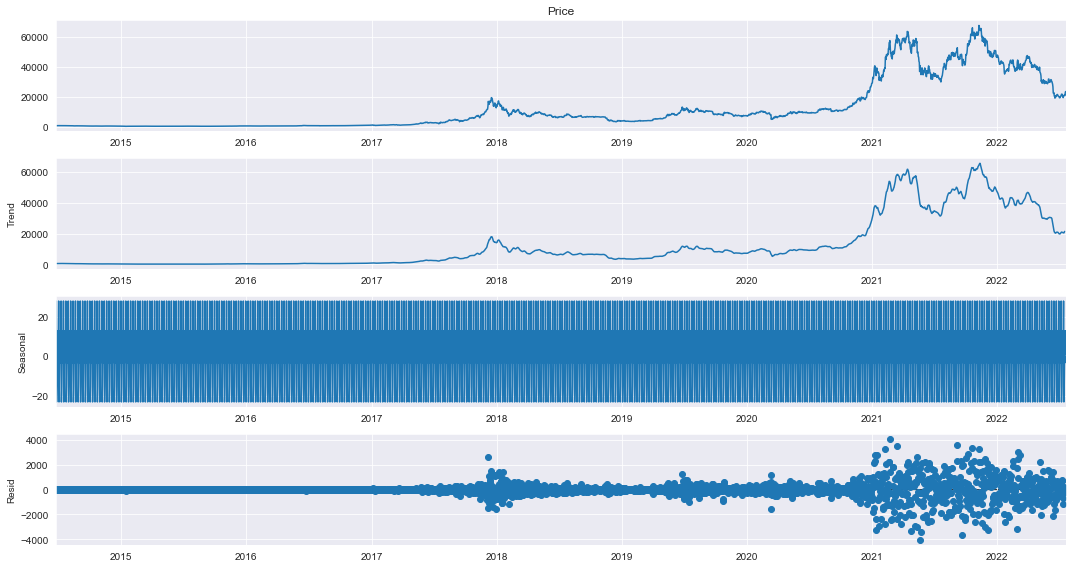

In [15]:
# Se grafica la descomposición de la serie de tiempo
fig = descomposicion.plot()
fig.set_size_inches((15, 8))
fig.tight_layout()
plt.show()

In [16]:
# Se obtienen los valores de las residualidad y tendencia
resid = descomposicion.resid
trend = descomposicion.trend

In [17]:
# Se crea un data set que se utilizará para concatenarlo a la copia de BTC_metals_df_reduced que se creará debajo (BTC_metals_reduced_df_3)
descomposicion_df = pd.DataFrame ()

In [18]:
# Se copias los valore a las columnas del nuevo data set
descomposicion_df ["Trend"] = trend.values
descomposicion_df ["Residuals"] = resid.values

In [19]:
# Se analizan los valores del data set que se concatenará debajo con la copia de BTC_metals_df_reduced que se creará oportunamente (BTC_metals_reduced_df_3)
descomposicion_df.count()

Trend        2943
Residuals    2943
dtype: int64

In [20]:
descomposicion_df.isnull().sum()

Trend        6
Residuals    6
dtype: int64

In [21]:
# Tres registros NaN
descomposicion_df.head()

,Trend,Residuals
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,590.300000,15.543527
4,596.571429,20.802061


In [22]:
# Aquí se ven los tres registro NaN que faltaban para completar los 2949 de BTC_metals_df_reduced (y tablas copias/modificadas)
descomposicion_df.tail()

,Trend,Residuals
2944,20787.614286,52.659204
2945,21370.371429,-160.520267
2946,NaN,NaN
2947,NaN,NaN
2948,NaN,NaN


In [23]:
# Se crea la tabla que se concatenerá y que fue referida en los comentarios arriba como BTC_metals_fv.csv
BTC_metals_df_reduced_3 = BTC_metals_df_reduced.copy()

In [24]:
# Se revisan sus columnas para chequear que [Date] no es el índice como en BTC_metals_df_reduced_2
BTC_metals_df_reduced_3.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Percentage_diff',
       'Target', 'Price_gold', 'Perc_diff_gold', 'Price_copper',
       'Perc_diff_copper', 'Price_aluminium', 'Perc_diff_aluminium'],
      dtype='object')

In [25]:
# Concatenando descomposicion_df con BTC_metals_df_reduced_3 en una nueva base de datos => BTC_metals_reduced_4
BTC_metals_reduced_4 = pd.concat([BTC_metals_df_reduced_3, descomposicion_df], axis=1, join="inner")

In [26]:
BTC_metals_reduced_4.head()

,Date,Price,Open,High,Low,Vol.,Percentage_diff,Target,Price_gold,Perc_diff_gold,Price_copper,Perc_diff_copper,Price_aluminium,Perc_diff_aluminium,Trend,Residuals
0,2014-06-23,591.2,603.6,604.7,582.9,2650.0,-2.06,0.0,1318.0,0.14,3.146,0.90,1892.5,0.21,NaN,NaN
1,2014-06-24,588.8,591.2,595.7,585.4,3080.0,-0.41,0.0,1320.9,0.22,3.147,0.03,1901.0,0.45,NaN,NaN
2,2014-06-25,568.5,588.8,589.6,566.9,3090.0,-3.45,0.0,1322.2,0.10,3.160,0.41,1903.5,0.13,NaN,NaN
3,2014-06-26,582.7,568.5,582.7,565.8,4150.0,2.51,1.0,1316.1,-0.46,3.161,0.03,1898.0,-0.29,590.300000,15.543527
4,2014-06-27,602.2,582.7,603.9,580.1,3390.0,3.35,1.0,1319.0,0.22,3.149,-0.38,1885.0,-0.68,596.571429,20.802061


In [28]:
BTC_metals_reduced_4.tail()

,Date,Price,Open,High,Low,Vol.,Percentage_diff,Target,Price_gold,Perc_diff_gold,Price_copper,Perc_diff_copper,Price_aluminium,Perc_diff_aluminium,Trend,Residuals
2944,2022-07-15,20825.1,20586.1,21178.1,20393.4,164670.0,1.16,1.0,1703.60,-0.13,3.2455,0.49,2344.0,0.69,20787.614286,52.659204
2945,2022-07-16,21209.9,20825.2,21561.3,20484.4,136890.0,1.85,1.0,1703.60,0.00,3.2455,0.00,2344.0,0.00,21370.371429,-160.520267
2946,2022-07-17,20785.6,21209.8,21654.4,20755.2,132810.0,-2.00,0.0,1703.60,0.00,3.2455,0.00,2344.0,0.00,NaN,NaN
2947,2022-07-18,22525.8,20785.6,22714.9,20770.6,279720.0,8.37,1.0,1710.20,0.39,3.3167,2.18,2435.0,3.88,NaN,NaN
2948,2022-07-19,23410.2,22529.3,23757.3,21581.8,308910.0,3.93,1.0,1708.05,-0.13,3.2965,-0.61,2386.0,-2.01,NaN,NaN


Paso 3 -> se crea la base de datos "BTC_metals_fv.csv" que se modelará según diversos modelos de ML en lo que resta del proyecto.

In [29]:
BTC_metals_reduced_4.to_csv ("D:\Luciano\Programación\Data science\Trabajo final\Bases de datos para modelos\BTC_metals_fv.csv", index=False, sep=";")